In [1]:
# import torch
# import gc

# # Clear CUDA cache
# torch.cuda.empty_cache()
# # Clear memory
# gc.collect()

# # Restart kernel
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [2]:
# Automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

In [3]:
from EDA import *
from data_preprocessing import *
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from seg_text_unet_model import *
from loss import *
import torch.optim as optim
from torchsummary import summary
import functools
from text_utils import load_tokenizer, collate_fn_text 



/home/cc/.local/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# # Define output directory for saving test plots
OUTPUT_DIR = "visualizations/test_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
#project_dir = os.path.dirname(os.path.abspath(__file__))
project_dir = os.getcwd() 
data_path = os.path.join(project_dir, "data")
print(data_path)

# EDA - image sizes, top text descriptions, sample data
#run_eda(data_path)

# Split data into train, val and test
split_data(data_path)



/home/cc/MMI_Unet_Lesion_Segmentation/data
Data split completed: 2183 training, 273 validation, 273 testing.


In [6]:
print("Loading tokenizer...")
tokenizer = load_tokenizer()
pad_id = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size
print(f"PAD token ID: {pad_id}")
print(f"Vocabulary Size: {vocab_size}")
print("-" * 30)

# --- Optional: Define max text length if different from dataset default ---
MAX_TEXT_LEN = 50 


# In your notebook, after tokenizer = load_tokenizer()
print(f"SOS token ID: {tokenizer.bos_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")
print(f"PAD token ID: {tokenizer.pad_token_id}")
print(f"UNK token ID: {tokenizer.unk_token_id}") # Check UNK too
print(f"Actual Vocab Size Used for Model: {vocab_size}") # The variable passed to model

Loading tokenizer...
Added 2 special tokens.
Tokenizer Vocabulary Size: 30522
SOS token: '[SOS]', ID: 30522
EOS token: '[EOS]', ID: 30523
PAD token: '[PAD]', ID: 0
PAD token ID: 0
Vocabulary Size: 30522
------------------------------
SOS token ID: 30522
EOS token ID: 30523
PAD token ID: 0
UNK token ID: 1
Actual Vocab Size Used for Model: 30522


In [7]:
# Preprocess the data - Resize and Augmentation
train_transforms = A.Compose([
    
    A.RandomScale(scale_limit=0.1, p=0.1),  # 10% zoom
    A.Resize(224, 224),
    ToTensorV2() #convert to tensor and normalize
])

val_test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()   
])

# print("Creating datasets...")
# train_dataset = SegmentationDataset(data_path, "train", transform=train_transforms)
# val_dataset = SegmentationDataset(data_path, "val", transform=val_test_transforms) 
# test_dataset = SegmentationDataset(data_path, "test",transform=val_test_transforms) 

# print(f"Number of training samples: {len(train_dataset)}")
# print(f"Number of validation samples: {len(val_dataset)}")
# print(f"Number of testing samples: {len(test_dataset)}")

print("Creating datasets...")
train_dataset = SegmentationDataset(data_path, "train", tokenizer=tokenizer, transform=train_transforms, max_text_len=MAX_TEXT_LEN)
val_dataset = SegmentationDataset(data_path, "val", tokenizer=tokenizer, transform=val_test_transforms, max_text_len=MAX_TEXT_LEN)
test_dataset = SegmentationDataset(data_path, "test", tokenizer=tokenizer, transform=val_test_transforms, max_text_len=MAX_TEXT_LEN)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print("-" * 30)


Creating datasets...
Number of training samples: 2183
Number of validation samples: 273
Number of testing samples: 273
------------------------------


In [8]:
collate_with_tokenizer = functools.partial(collate_fn_text, tokenizer=tokenizer)


In [9]:
print("Creating data loaders...")
BATCH_SIZE = 8
NUM_WORKERS = 0 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_with_tokenizer, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_with_tokenizer, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_with_tokenizer, num_workers=NUM_WORKERS)


print("Data loaders created.")
print("-" * 30)


Creating data loaders...
Data loaders created.
------------------------------


In [10]:
print("Checking one batch from train_loader...")
try:
    images_batch, masks_batch, input_ids, target_ids, target_padding_mask = next(iter(train_loader))
    print("Batch loaded successfully!")
    print(f"Images shape: {images_batch.shape}")       # Should be [B, C, H, W]
    print(f"Masks shape: {masks_batch.shape}")         # Should be [B, 1, H, W]
    print(f"Input IDs shape: {input_ids.shape}")       # Should be [B, T]
    print(f"Target IDs shape: {target_ids.shape}")     # Should be [B, T]
    print(f"Padding mask shape: {target_padding_mask.shape}") # Should be [B, T]
    print(f"Input IDs example: {input_ids[0, :15]}...") # Print first few tokens
    print(f"Target IDs example: {target_ids[0, :15]}...")
except Exception as e:
    print(f"Error loading batch: {e}")
print("-" * 30)

Checking one batch from train_loader...
Batch loaded successfully!
Images shape: torch.Size([8, 3, 224, 224])
Masks shape: torch.Size([8, 1, 224, 224])
Input IDs shape: torch.Size([8, 17])
Target IDs shape: torch.Size([8, 17])
Padding mask shape: torch.Size([8, 17])
Input IDs example: tensor([30522,  8673,  3004,  2585,    16,  2159,  4291,  3685,    16,  5500,
         2279,  2572,    18, 30523,     0])...
Target IDs example: tensor([ 8673,  3004,  2585,    16,  2159,  4291,  3685,    16,  5500,  2279,
         2572,    18, 30523,     0,     0])...
------------------------------


In [11]:
# for images, masks, text_descriptions in train_loader:
#     print(f"Image type: {type(images)}")
#     print(f"Image shape: {images.shape}")
#     print(f"Image data type: {images.dtype}") 
    
#     print(f"Text description type: {type(text_descriptions)}")

#     print(f"Mask type: {type(masks)}")
#     print(f"Mask shape: {masks.shape}")
#     print(f"Mask data type: {masks.dtype}")


#     break

In [12]:
from torchinfo import summary
from seg_text_unet_model import JointSegTextUNet
import torch

#model = MMI_UNet(out_channels=1)

#summary(model)

In [13]:
# images = torch.randn(1, 3, 224, 224)  
# reports = [
# "Bilateral pulmonary infection, two infected areas, all left lung and middle right lung."
# ]

# # The model handles the text encoding internally
# segmentation_maps = model(images, reports)

In [14]:
# print(segmentation_maps)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
    import importlib
    import inspect
    import seg_text_unet_model # Import the whole module first

    # Force reload (in case caching is being stubborn)
    importlib.reload(seg_text_unet_model)
    print("Reloaded seg_text_unet_model module.")

    # Explicitly import the class *after* reload
    from seg_text_unet_model import ConvNeXtEncoder

    # Inspect the signature of the __init__ method Python is actually seeing
    print("Inspecting ConvNeXtEncoder.__init__ signature:")
    try:
        print(inspect.signature(ConvNeXtEncoder.__init__))
    except Exception as e:
        print(f"Could not inspect signature: {e}")

    # Print the file Python loaded the class from
    print("\nFile path for ConvNeXtEncoder:")
    try:
        print(inspect.getfile(ConvNeXtEncoder))
    except Exception as e:
        print(f"Could not get file path: {e}")

    print("-" * 30)

Reloaded seg_text_unet_model module.
Inspecting ConvNeXtEncoder.__init__ signature:
(self)

File path for ConvNeXtEncoder:
/home/cc/MMI_Unet_Lesion_Segmentation/seg_text_unet_model.py
------------------------------


In [17]:
from loss import *
from train import *
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


EMBED_DIM = 768 # Matching ConvNeXt F4, RATCHET used 512
NHEAD = 8
NUM_DECODER_LAYERS = 6
DIM_FEEDFORWARD = 3072 # Typically 4*EMBED_DIM, RATCHET used 2048
MAX_TEXT_SEQ_LEN = 50  #based on dataset
DROPOUT = 0.1 # RATCHET used 0.2

print("Initializing model...")
model = JointSegTextUNet(
    seg_out_channels=1, 
    vocab_size=vocab_size+2, 
    embed_dim=EMBED_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    max_text_seq_len=MAX_TEXT_SEQ_LEN,
    dropout=DROPOUT,
    pad_token_id=pad_id 
).to(device) 

print("Model initialized successfully.")
# Print model summary or parameter count
# print(model)
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total trainable parameters: {total_params:,}")
print("-" * 30)




Initializing model...
Model initialized successfully.
------------------------------


In [18]:
import sys
import os
import contextlib
import matplotlib.pyplot as plt 
import torch 

# --- Configuration ---
LOG_FILE_PATH = "training_log_segtext_cloud.txt"
TEST_OUTPUT_DIR = "visualizations/test_outputs"

os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)
print(f"Test image outputs will be saved to: {TEST_OUTPUT_DIR}")
print(f"Training and testing logs will be saved to: {LOG_FILE_PATH}") 


# --- Context Manager for Logging ---
@contextlib.contextmanager
def log_stdout_to_file(filename, mode='w'): 
    original_stdout = sys.stdout
    try:
        with open(filename, mode) as log_file: # Use the mode argument
            sys.stdout = log_file
            yield # Executes the code within the 'with' block
    finally:
        sys.stdout = original_stdout # Restores normal printing


Test image outputs will be saved to: visualizations/test_outputs
Training and testing logs will be saved to: training_log_segtext_cloud.txt


In [ ]:

EPOCHS = 30
LEARNING_RATE = 1e-4

# Train the model and save output to log file
print("Starting Training...") # Prints to notebook
with log_stdout_to_file(LOG_FILE_PATH): # Use 'w' to overwrite/start log
    print("--- Training Log Start ---") # Goes to file
    train_text_phase(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    pad_token_id=pad_id, 
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE
)
    print("--- Training Log End ---") # Goes to file
print("Training Finished.") # Prints to notebook



Starting Training...


/home/cc/.local/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Training Finished.


In [19]:
import nltk
print("Checking/downloading NLTK resources...")
try:
    nltk.data.find('tokenizers/punkt')
except:
    print("Downloading punkt...")
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/wordnet') # Check for wordnet
except:
    print("Downloading wordnet...")
    nltk.download('wordnet', quiet=True) # Needed for METEOR
# try: nltk.data.find('????/omw-1.4') # Wordnet might require omw-1.4 too
# except: nltk.download('omw-1.4', quiet=True) # Uncomment if meteor throws omw error
print("NLTK check done.")

Checking/downloading NLTK resources...
NLTK check done.


--- Starting Evaluation ---
Initializing model for inference...
Model weights loaded successfully from medsegtext_text_phase.pth
Evaluating on 273 test samples...

--- Displaying Sample 1 ---


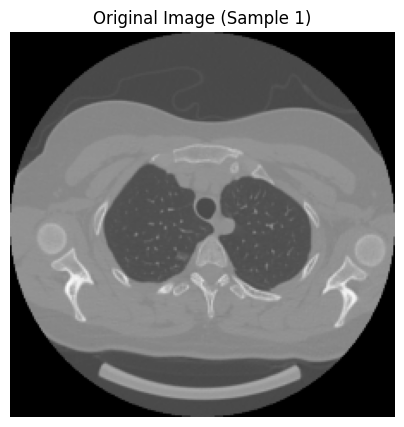

Ground Truth: unilateral pulmonary infection, one infected areas, middle left lung.
Predicted:    unilateral pulmonary infection, one infected areas, left lung and middle right lung.

--- Displaying Sample 2 ---


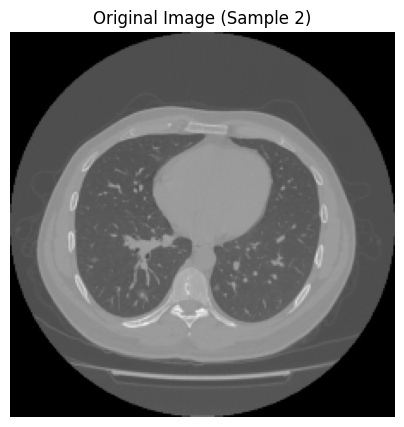

Ground Truth: bilateral pulmonary infection, three infected areas, middle left lung and middle right lung.
Predicted:    bilateral pulmonary infection, three infected areas, middle left lung and lower right lung.

--- Displaying Sample 3 ---


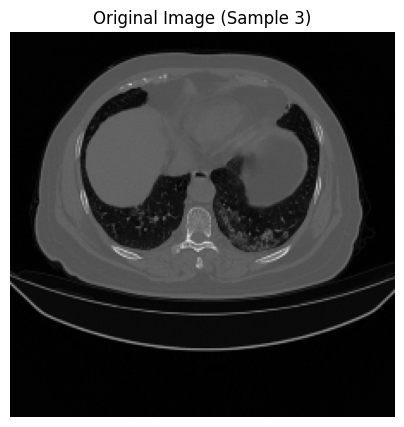

Ground Truth: bilateral pulmonary infection, three infected areas, middle left lung and middle right lung.
Predicted:    bilateral pulmonary infection, two infected areas, middle left lung and middle right lung.

--- Displaying Sample 4 ---


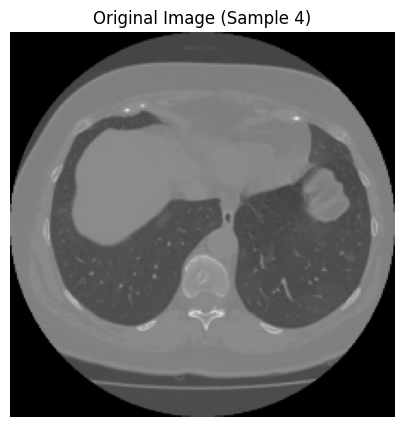

Ground Truth: bilateral pulmonary infection, three infected areas, middle left lung and middle right lung.
Predicted:    unilateral pulmonary infection, one infected areas, left lung and lower right lung.

--- Displaying Sample 5 ---


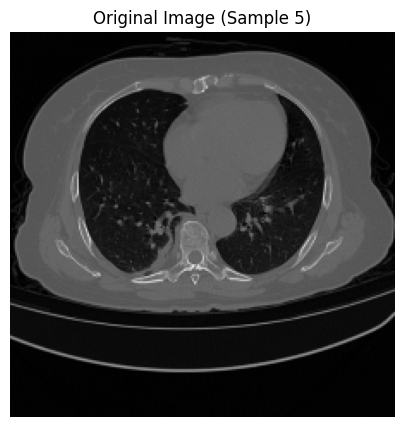

Ground Truth: bilateral pulmonary infection, three infected areas, upper left lung and upper right lung.
Predicted:    bilateral pulmonary infection, two infected areas, middle left lung and upper right lung.
  Processed 88/273 samples...
  Processed 168/273 samples...
  Processed 248/273 samples...

Finished evaluation loop (273 samples processed) in 30.78 seconds.

Calculating Metrics (Based on 273 Valid Samples)...
Metrics Calculation Complete.
  BLEU-1: 0.9180
  BLEU-2: 0.8863
  BLEU-3: 0.8492
  BLEU-4: 0.8036
  METEOR: 0.9279
  ROUGE-L: 0.9107
--- Evaluation Finished ---

Overall Evaluation Metrics:
  BLEU-1: 0.9180
  BLEU-2: 0.8863
  BLEU-3: 0.8492
  BLEU-4: 0.8036
  METEOR: 0.9279
  ROUGE-L: 0.9107


In [20]:
# Test with metrics
from text_inference import evaluate_model # Assuming the function is in text_inference.py

# --- Define Model Configuration (parameters used for training) ---
model_config = {
    'seg_out_channels': 1,
    'vocab_size': 30524, # Make sure this is correct
    'embed_dim': EMBED_DIM, # Assuming these are defined earlier in notebook
    'nhead': NHEAD,
    'num_decoder_layers': NUM_DECODER_LAYERS,
    'dim_feedforward': DIM_FEEDFORWARD,
    'max_text_seq_len': MAX_TEXT_SEQ_LEN,
    'dropout': DROPOUT,
    'pad_token_id': pad_id # Assuming pad_id is defined earlier
}
saved_model_path = "medsegtext_text_phase.pth"

# --- Call the Evaluation Function ---
# Ensure test_loader, tokenizer, device are available from previous cells
evaluation_results = evaluate_model(
    model_path=saved_model_path,
    model_config=model_config,
    test_loader=test_loader,
    tokenizer=tokenizer,
    device=device,
    display_limit=5 # How many samples to show images/text for
)

if evaluation_results:
    print("\nOverall Evaluation Metrics:")
    for metric, score in evaluation_results.items():
        print(f"  {metric}: {score:.4f}")
else:
    print("\nEvaluation did not produce results.")


In [ ]:
# SEGEMENTATION TESTING
# print("Starting Testing...") # Prints to notebook
# with log_stdout_to_file(LOG_FILE_PATH, 'a'): # Use 'a' to append to the log file
#     print("--- Testing Log Start ---") # Goes to file

#     model.eval()
#     total_dice, total_iou, num_samples = 0, 0, 0

#     with torch.no_grad():
#         for i, (image, mask, text) in enumerate(test_loader):
#             # Model computations on GPU
#             image, mask = image.to(device), mask.to(device)
#             pred = model(image, text)
#             pred = torch.sigmoid(pred)

#             # Metrics computation on GPU
#             dice = dice_score(pred, mask).item()
#             iou = iou_score(pred, mask).item()
#             total_dice += dice
#             total_iou += iou
#             num_samples += 1

#             # Visualization - need to move to CPU for matplotlib
#             if i < 5:  
#                 plt.figure(figsize=(20, 5))
                
#                 # Move to CPU only for visualization
#                 img_display = image.cpu()[0].permute(1, 2, 0).numpy()
#                 mask_display = mask.cpu()[0].squeeze().numpy()
#                 pred_display = pred.cpu()[0].squeeze().numpy()
                
#                 plt.subplot(1, 3, 1)
#                 plt.imshow(img_display)
#                 plt.title("Input Image")
                
#                 plt.subplot(1, 3, 2)
#                 plt.imshow(mask_display, cmap="gray")
#                 plt.title("Ground Truth")
                
#                 plt.subplot(1, 3, 3)
#                 plt.imshow(pred_display, cmap="gray")
#                 plt.title(f"Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}")
                
#                 plt.tight_layout()
#                 plt.show()
#                 plot_path = os.path.join(TEST_OUTPUT_DIR, f"test_case_{i}.png")
#                 plt.savefig(plot_path, bbox_inches="tight")
#                 plt.close()
        
#                 print(f"Saved test visualization: {plot_path}")

#     print(f"Test Dice Score: {total_dice / num_samples:.4f}")
#     print(f"Test IoU Score: {total_iou / num_samples:.4f}")
#     print("--- Testing Log End ---") # Goes to file
# print("Testing Finished.") # Prints to notebook

In [ ]:
# SEGEMENTATION TESTING
# print("Starting Testing with threshold output...") # Prints to notebook
# with log_stdout_to_file(LOG_FILE_PATH, 'a'): # Use 'a' to append to the log file
#     print("--- Testing Log Start ---") # Goes to file

#     model.eval()
#     total_dice, total_iou, num_samples = 0, 0, 0

#     with torch.no_grad():
#         for i, (image, mask, text) in enumerate(test_loader):
#             # Model computations on GPU
#             image, mask = image.to(device), mask.to(device)
#             pred = model(image, text)
#             pred = torch.sigmoid(pred)

#             # Metrics computation on GPU
#             dice = dice_score(pred, mask).item()
#             iou = iou_score(pred, mask).item()
#             total_dice += dice
#             total_iou += iou
#             num_samples += 1

#             # Visualization - need to move to CPU for matplotlib
#             if i < 5:
#                 plt.figure(figsize=(20, 5))

#                 # Move to CPU only for visualization
#                 img_display = image.cpu()[0].permute(1, 2, 0).numpy()
#                 mask_display = mask.cpu()[0].squeeze().numpy()
#                 pred_probabilities_display = pred.cpu()[0].squeeze().numpy() # Get probabilities

#                 # --- Apply threshold for visualization ---
#                 threshold = 0.5
#                 pred_binary_display = (pred_probabilities_display > threshold).astype(float) # Convert boolean to float for imshow
#                 # -----------------------------------------

#                 plt.subplot(1, 3, 1)
#                 plt.imshow(img_display)
#                 plt.title("Input Image")

#                 plt.subplot(1, 3, 2)
#                 plt.imshow(mask_display, cmap="gray")
#                 plt.title("Ground Truth")

#                 plt.subplot(1, 3, 3)
#                 # --- Use the binary mask for plotting ---
#                 plt.imshow(pred_binary_display, cmap="gray")
#                 # ----------------------------------------
#                 plt.title(f"Prediction (Thresholded > {threshold})\nDice: {dice:.4f}, IoU: {iou:.4f}")

#                 plt.tight_layout()
#                 plt.show() 
#                 plot_path = os.path.join(TEST_OUTPUT_DIR, f"thresholded_test_case_{i}.png")
#                 plt.savefig(plot_path, bbox_inches="tight")
#                 plt.close()

#                 print(f"Saved test visualization: {plot_path}") # This will go to the log file

#     # --- Recalculate average metrics AFTER the loop ---
#     avg_dice = total_dice / num_samples
#     avg_iou = total_iou / num_samples
#     # ----------------------------------------------------

#     # --- Print final averages to the log file ---
#     print(f"Average Test Dice Score: {avg_dice:.4f}")
#     print(f"Average Test IoU Score: {avg_iou:.4f}")
#     # ------------------------------------------
#     print("--- Testing Log End ---") # Goes to file
# print("Testing Finished.") # Prints to notebook
